Current Time = 19:31:59

key = CPU, Hash=0
K = 2.0, T = 5, Run-time =    8.75 (sec.)
K = 2.5, T = 5, Run-time =   13.60 (sec.)
K = 3.0, T = 5, Run-time =   19.77 (sec.)

key = CPU, Hash=1
K = 2.0, T = 5, Run-time =    3.92 (sec.)
K = 2.5, T = 5, Run-time =    6.18 (sec.)
K = 3.0, T = 5, Run-time =    9.18 (sec.)

key = GPU, Hash=0
K = 2.0, T = 5, Run-time =    0.47 (sec.)
K = 2.5, T = 5, Run-time =    0.56 (sec.)
K = 3.0, T = 5, Run-time =    0.79 (sec.)

key = GPU, Hash=1
K = 2.0, T = 5, Run-time =    0.91 (sec.)
K = 2.5, T = 5, Run-time =    1.50 (sec.)
K = 3.0, T = 5, Run-time =    2.23 (sec.)

Plotting .... 


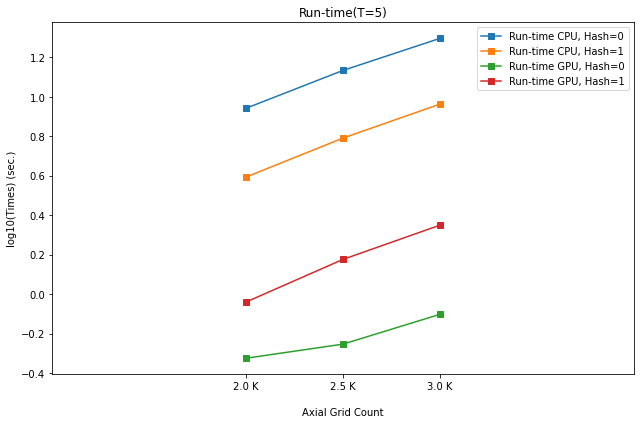


Done.
Wall time: 1min 12s


In [5]:
%%time

from IPython.display import clear_output
clear_output()

# 저니크 모멘트 계산 

from AZernike import *

# 차수에 따른 연산 속도 

print_curr_time()

line = "*"*60
line2 = "\n" + line 

def test_zernike_moments( datas, use_gpus, use_hashs, Ks, Ts, **options ) : 
    
    if is_array( use_gpus ) :
        for use_gpu in use_gpus :
            options = {}
            options[ "debug" ] = get_option( "debug", **options )
            options[ "use_gpu" ] = use_gpu 
            options[ "use_hash" ] = 0 
            options[ "use_thread"] = 0 
            
            test_zernike_moments( datas, use_gpu, use_hashs, Ks, Ts, **options )
        pass
    elif is_array( use_hashs ) :
        for use_hash in use_hashs :
            options = {}
            options[ "debug" ] = get_option( "debug", **options )
            options[ "use_gpu" ] = use_gpus 
            options[ "use_hash" ] = use_hash 
            options[ "use_thread"] = 0 
            
            test_zernike_moments( datas, use_gpus, use_hash, Ks, Ts, **options )
        pass 
    else :
        debug = get_option( "debug", **options )
        use_hash = get_option( "use_hash", ** options )
    
        device = "GPU" if options["use_gpu"] else "CPU"
        multi = "Multi " if options["use_thread"] else ""
        
        key = f"{multi}{device}, Hash={use_hash}"
        print()
        print( f"key = {key}")
        
        if is_scalar( Ks ) :
            Ks = [ Ks ]
        pass
    
        if is_scalar( Ts ) :
            Ts = [ Ts ]
        pass
        
        if not key in datas :             
            data = {}
            data[ "Ks"] = Ks
            data[ "run_times" ] = []
            datas[ key ] = data 
        pass
    
        data = datas[ key ]
        
        run_times = data[ "run_times" ]
        
        for K in Ks : 
            options[ "hash" ] = {} 
        
            for T in Ts :
                circle_type = "outer" 

                rho, theta, x, y, dx, dy, k = rho_theta( 1000*K, circle_type, **options ) 

                if debug : print( f"rho shape = {rho.shape}" )

                img = cv.imread( 'image/lenna.png', 0 )

                if debug : print( "img shape= ", img.shape )

                img_org = img 

                np = cupy if options['use_gpu'] else numpy

                img = cv.resize( img_org, (int(K*1_000), int(K*1_000)), interpolation=cv.INTER_AREA )

                if options['use_gpu']  : 
                    img = np.array( img )
                pass

                img_org = img

                if debug : 
                    print( "img shape= ", img.shape ) 
                    print( line )
                pass
                
                moments, run_time = calc_moments(T, img, rho, theta, dx, dy, **options )
                
                print( f"K = {K}, T = {T}, Run-time = {run_time:7.2f} (sec.)" ) 
                
                run_times.append( run_time )
            pass # T
        pass # K
    pass
pass
    
Ks = numpy.arange( 2, 3.1, 0.5 ) 

use_gpus =  [ 0, 1 ]
use_hashs = [ 0, 1 ]

T_MAX = 25 

max_mem = max_gpu_memory() if False else max_cpu_memory() 

if max_mem < 8 :
    T_MAX = 18
elif max_mem < 25 :
    T_MAX = 20
pass

T_MAX = 5 

T = T_MAX 

datas = { }

debug = 0

test_zernike_moments( datas, use_gpus, use_hashs, Ks, T, debug=debug ) 

print( "\nPlotting .... ")
    
# 서브 챠트 생성 
row_cnt = 1
col_cnt = 1

fig, charts = plt.subplots( row_cnt, col_cnt, figsize=(9*col_cnt, 6*row_cnt) )
charts = charts.ravel() if row_cnt*col_cnt > 1 else [charts]
chart_idx = 0 
chart = charts[ chart_idx ] ; chart_idx += 1
chart.set_title( f"Run-time(T={T})" ) 

for key in datas : 
    data = datas[ key ]
    
    Ks = data[ "Ks" ]
    run_times = data[ "run_times" ]
    
    x = Ks
    y = numpy.log10( run_times ) 
    
    label = f"Run-time {key}"    
    chart.plot( x, y, marker="s", label=label )
    chart.set_xlabel( "\nAxial Grid Count" )
    chart.set_ylabel( "log10(Times) (sec.)")
    chart.set_xticks( x )
    chart.set_xticklabels( [ f"{k} K" for k in x ] )
    chart.set_xlim( numpy.min(x) -1, numpy.max(x) + 1 )

    chart.legend()
pass

plt.tight_layout(); plt.show()

print( "\nDone." )
